## Transfer Learning from AlexNet, VGG16, and ResNet18

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '~/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


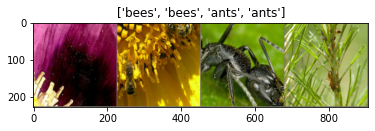

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


## Transfer Learning using ResNet18


In [6]:
# Load the pre-trained ResNet18
model_ft = models.resnet18(pretrained=True)

print(model_ft)

num_ftrs = model_ft.fc.in_features
print('num_ftrs = ', num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Training the model for the hymenoptera_data (2 classes)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6095 Acc: 0.6721
val Loss: 0.2775 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5420 Acc: 0.7500
val Loss: 0.3400 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.5623 Acc: 0.7951
val Loss: 0.2325 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3912 Acc: 0.8402
val Loss: 0.4332 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.5656 Acc: 0.7910
val Loss: 0.3104 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4431 Acc: 0.8238
val Loss: 0.2774 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3878 Acc: 0.8607
val Loss: 0.2445 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3289 Acc: 0.8648
val Loss: 0.2602 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3934 Acc: 0.8279
val Loss: 0.2427 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3330 Acc: 0.8525
val Loss: 0.2358 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2925 Acc: 0.8770
val Loss: 0.2306 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.4679 Acc: 0.7951
val Loss: 0.2409 Acc: 0.9150

Ep

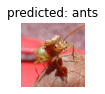

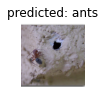

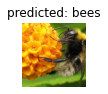

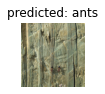

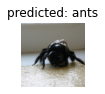

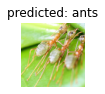

In [8]:
# Visualize some of the prediction results
visualize_model(model_ft)


## Transfer Learning using AlexNet


In [21]:
model_ft = models.alexnet(pretrained=True)
print(model_ft)

print(model_ft.classifier[6].out_features) # 1000 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# Freeze training for all layers
#for param in model_ft.features.parameters():
#    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features) # Replace the model classifier
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
# 
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [12]:
# Training the model for the hymenoptera_data (2 classes)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.8389 Acc: 0.6434
val Loss: 0.6629 Acc: 0.5686

Epoch 1/24
----------
train Loss: 0.6698 Acc: 0.5902
val Loss: 0.6274 Acc: 0.6928

Epoch 2/24
----------
train Loss: 0.6099 Acc: 0.6434
val Loss: 0.6099 Acc: 0.7386

Epoch 3/24
----------
train Loss: 0.5117 Acc: 0.7705
val Loss: 0.4627 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5524 Acc: 0.7500
val Loss: 0.6032 Acc: 0.6863

Epoch 5/24
----------
train Loss: 0.4307 Acc: 0.7992
val Loss: 0.4690 Acc: 0.7320

Epoch 6/24
----------
train Loss: 0.4562 Acc: 0.8238
val Loss: 0.4821 Acc: 0.7778

Epoch 7/24
----------
train Loss: 0.3975 Acc: 0.8279
val Loss: 0.3642 Acc: 0.8301

Epoch 8/24
----------
train Loss: 0.3300 Acc: 0.8689
val Loss: 0.3186 Acc: 0.8301

Epoch 9/24
----------
train Loss: 0.2909 Acc: 0.8689
val Loss: 0.3213 Acc: 0.8366

Epoch 10/24
----------
train Loss: 0.1892 Acc: 0.9467
val Loss: 0.3047 Acc: 0.8627

Epoch 11/24
----------
train Loss: 0.2231 Acc: 0.9016
val Loss: 0.2982 Acc: 0.8497

Ep

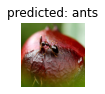

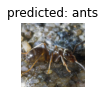

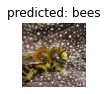

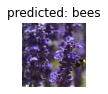

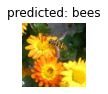

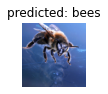

In [14]:
# Visualize some of the prediction results
visualize_model(model_ft)


## Transfer Learning using VGG16


In [23]:
model_ft = models.vgg16_bn(pretrained=True)
print(model_ft)

print(model_ft.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/kurita/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [24]:
# Freeze training for all layers
#for param in model_ft.features.parameters():
#    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features) # Replace the model classifier
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [25]:
# 
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [26]:
# Training the model for the hymenoptera_data (2 classes)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5668 Acc: 0.7705
val Loss: 0.2949 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.3677 Acc: 0.8361
val Loss: 0.1884 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.2776 Acc: 0.8730
val Loss: 0.2675 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.1914 Acc: 0.9303
val Loss: 0.2031 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.2385 Acc: 0.9016
val Loss: 0.2939 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.2382 Acc: 0.8934
val Loss: 0.3563 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.3298 Acc: 0.8648
val Loss: 0.2707 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.1873 Acc: 0.9221
val Loss: 0.2774 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2324 Acc: 0.9221
val Loss: 0.2346 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.1674 Acc: 0.9549
val Loss: 0.2322 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.1210 Acc: 0.9590
val Loss: 0.2379 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2131 Acc: 0.9303
val Loss: 0.2296 Acc: 0.9346

Ep

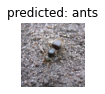

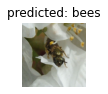

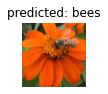

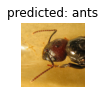

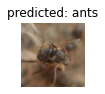

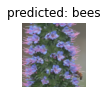

In [27]:
# Visualize some of the prediction results
visualize_model(model_ft)
